# Density-based clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.cluster import DBSCAN
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
# read customer dataframe
df = pd.read_csv('datasets/customer_dataframe.csv', sep='\t', index_col=0)

Perform some dimensionality reduction by picking only the main attributes
for describing a customer's shopping behaviour

In [3]:
df_reduct = df[['TProd', 'MeanProdOrder', 'MeanSaleOrder', 'MeanPSale']]
df_reduct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4333 entries, 17850 to 12713
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TProd          4333 non-null   int64  
 1   MeanProdOrder  4333 non-null   float64
 2   MeanSaleOrder  4333 non-null   float64
 3   MeanPSale      4333 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 169.3 KB


In [4]:
df_reduct.describe()

,TProd,MeanProdOrder,MeanSaleOrder,MeanPSale
count,4333.000000,4333.000000,4333.000000,4333.000000
mean,1129.535657,201.104614,327.882896,3.492819
std,4692.695935,274.590134,395.336014,8.997404
min,0.000000,0.000000,-0.000000,0.122000
25%,157.000000,80.500000,155.050000,2.160000
50%,370.000000,140.167000,241.900000,2.834000
75%,971.000000,237.750000,371.560000,3.712000
max,196556.000000,7824.000000,9904.875000,434.650000


<AxesSubplot:>

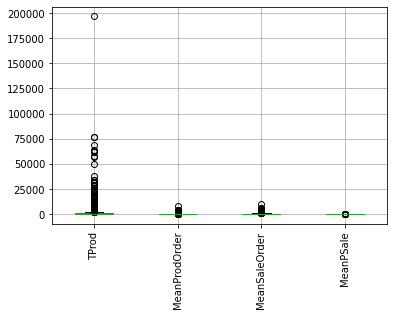

In [5]:
df_reduct.boxplot(list(df_reduct.columns), rot=90)

## Preprocessing - Normalization

In [6]:
# standard normalization: remove mean and scale to unit variance
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_norm = scaler.fit_transform(df_reduct.values)
df_norm = pd.DataFrame(df_norm, columns=df_reduct.columns)

In [7]:
df_norm.describe()

,TProd,MeanProdOrder,MeanSaleOrder,MeanPSale
count,4333.000000,4333.000000,4333.000000,4333.000000
mean,0.005747,0.025704,0.033103,0.007757
std,0.023875,0.035096,0.039913,0.020706
min,0.000000,0.000000,0.000000,0.000000
25%,0.000799,0.010289,0.015654,0.004690
50%,0.001882,0.017915,0.024422,0.006241
75%,0.004940,0.030387,0.037513,0.008262
max,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:>

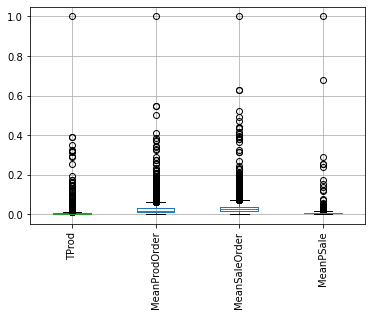

In [8]:
df_norm.boxplot(list(df_norm.columns), rot=90)

## DBSCAN

In [9]:
from scipy.spatial.distance import pdist, squareform
dist = pdist(X=df_norm, metric='euclidean')  #pair-wise distance: how every record is far from all others
dist = squareform(dist) #distance matrix given the vector dist

In [10]:
kmin = 3
kmax = 30
kth_distances = {}
for k in range(kmin, kmax + 1): kth_distances[k] = list()   # initialize k lists

# for every row of the distance matrix...
for d in dist:
    # argsort returns the indexes that would sort d
    indexes_to_sort_d = np.argsort(d)
    for k in range(kmin, kmax + 1):
        # append to kth_distances[k] the value in d that corresponds
        # to the distance of the i-th point (record) from its k-th nn.
        # it's like: kth_distances[k].append(sorted_d[k])), but we get "sorted_d[k]" by d[indexes_to_sort_d[k]]
        kth_distances[k].append(d[ indexes_to_sort_d[ k ] ])

Plot, for every value of k in [kmin, kmax], the sorted distances

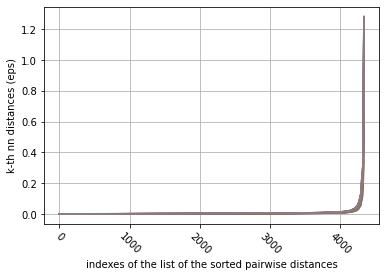

In [11]:
for k in kth_distances.keys():
    plt.plot(range(0, len(kth_distances[k])), sorted(kth_distances[k]))

plt.ylabel('k-th nn distances (eps)')
plt.xlabel('indexes of the list of the sorted pairwise distances')
plt.xticks(rotation=-45)
plt.tick_params(axis='both', which='major')
plt.grid()
plt.show()

Same plot with the median value of [kmin, kmax] for every x because the plot seems uniform for every k.<br>
Just to have a cleaner view of the plot

In [12]:
kmedian = list()
for i in tqdm(range(len(kth_distances[kmin])), total=len(kth_distances[kmin]), desc='Computing the median of the functions'):
    aux = list()
    for k in kth_distances.keys():
        aux.append(sorted(kth_distances[k])[i])
    kmedian.append(np.median(aux))

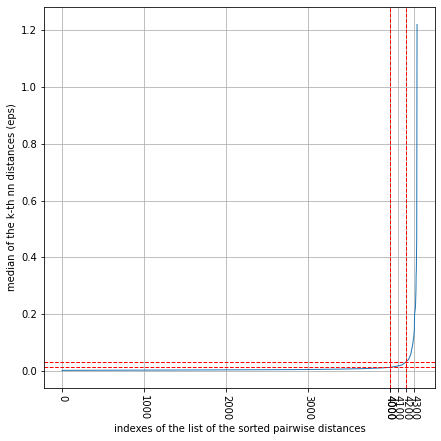

Elbow area of the median of kth-NN distances plot:
Low:	x = 4000 --> eps = 0.011832122874249798
High:	x = 4200 --> eps = 0.03131958136158988


In [13]:
figure(figsize=(7,7))
plt.plot(range(0,len(kth_distances[kmin])), kmedian, linewidth=1) #kmedian already sorted
plt.ylabel('median of the k-th nn distances (eps)')
plt.xlabel('indexes of the list of the sorted pairwise distances')

xticks = []
for i in range(0, 4001, 1000): xticks.append(i)
for i in range(4000, len(kth_distances[kmin]), 100): xticks.append(i)
plt.xticks(xticks, rotation=-90)
plt.tick_params(axis='both', which='major')
plt.grid()
low_elb = 4000
high_elb = 4200
plt.axvline(x=low_elb, color='red', linestyle='--', linewidth=1)
plt.axhline(y=sorted(kmedian)[low_elb], color='red', linestyle='--', linewidth=1)
plt.axvline(x=high_elb, color='red', linestyle='--', linewidth=1)
plt.axhline(y=sorted(kmedian)[high_elb], color='red', linestyle='--', linewidth=1)
plt.show()
print("Elbow area of the median of kth-NN distances plot:")
print(f"Low:\tx = {low_elb} --> eps = {kmedian[low_elb]}")  # kmedian is already sorted
print(f"High:\tx = {high_elb} --> eps = {kmedian[high_elb]}")  # kmedian is already sorted

### Grid search for _eps_ and <i>min_samples</i>

In [14]:
from sklearn.neighbors import NearestNeighbors

# func to get metrics to evaluate the clustering done with certain eps and min_samples
def get_metrics(eps, ms, dataset, iter_):

    # Fitting
    dbscan = DBSCAN(eps=eps, min_samples=ms)
    dbscan.fit(dataset)

    # Mean Noise Point Distance metric
    noise_indices = (dbscan.labels_ == -1)  #list of booleans
    if True in noise_indices:
        nbrs = NearestNeighbors(n_neighbors = 10).fit(dataset)
        distances, _ = nbrs.kneighbors(dataset)   #returns indices of and distances to the neighbors of each point
        noise_distances = distances[noise_indices, 1 : ]
        noise_mean_distance = round(noise_distances.mean(), 3)
    else:
        noise_mean_distance = None

    # Number of found Clusters metric
    number_of_clusters = len(np.unique(dbscan.labels_[dbscan.labels_ >= 0]))

    # Log
    # print("%3d | Tested with eps = %3s and min_samples = %3s | %5s\t%4s" % (iter_, eps, ms, str(noise_mean_distance), number_of_clusters))

    return noise_mean_distance, number_of_clusters

In [15]:
# Lists for the params to test in the grid search
gs_eps_list = [round(eps, 3) for eps in np.arange(kmedian[low_elb], kmedian[high_elb], 0.001)]
gs_ms_list = range(kmin, 10, 1) # after k=9 we always get 1 cluster

print("Grid search parameters:")
print("eps:", gs_eps_list)
print("min_samples:", list(gs_ms_list))

Grid search parameters:
eps: [0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.02, 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028, 0.029, 0.03, 0.031]
min_samples: [3, 4, 5, 6, 7, 8, 9]


Dataframes to contain the results of the grid search

In [16]:
# Dataframe for the metric on the avg distance of the noise points from the K nearest ones
results_noise = pd.DataFrame(
    data = np.zeros((len(gs_eps_list),len(gs_ms_list))), # Empty dataframe
    columns = gs_ms_list,
    index = gs_eps_list
)

# Dataframe for the metric on the number of clusters
results_clusters = pd.DataFrame(
    data = np.zeros((len(gs_eps_list),len(gs_ms_list))), # Empty dataframe
    columns = gs_ms_list,
    index = gs_eps_list
)

Grid search cycle:

In [17]:
#print("ITER| INFO%s |  DIST    # CLUSTERS" % (' '*39))
#print("-"*73)

# Grid search cycle
i = 0
for eps in tqdm(gs_eps_list, total=len(gs_eps_list), desc='Proceeding of grid search'):
    for ms in gs_ms_list:
        i += 1

        # Compute metrics
        noise_metric, clusters_metric = get_metrics(eps, ms, df_norm, i)

        # Insert results in the apposite dataframes
        results_noise.loc[eps, ms] = noise_metric
        results_clusters.loc[eps, ms] = clusters_metric

Results of grid search:

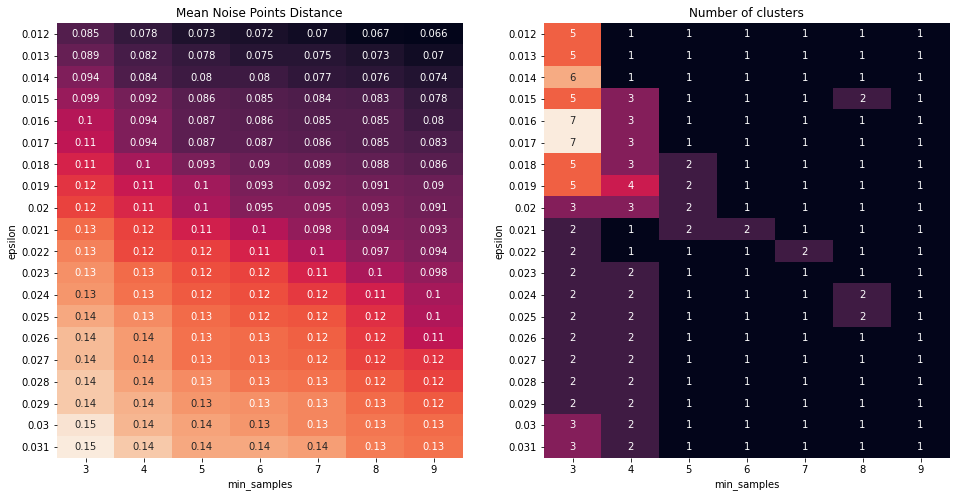

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
sns.heatmap(results_noise, annot = True, ax = ax1, cbar = False).set_title("Mean Noise Points Distance")
sns.heatmap(results_clusters, annot = True, ax = ax2, cbar = False).set_title("Number of clusters")
ax1.set_xlabel("min_samples")
ax2.set_xlabel("min_samples")
ax1.set_ylabel("epsilon")
ax2.set_ylabel("epsilon")
plt.show()

(array([-1,  0,  1,  2], dtype=int64), array([  97, 4223,    4,    9], dtype=int64))


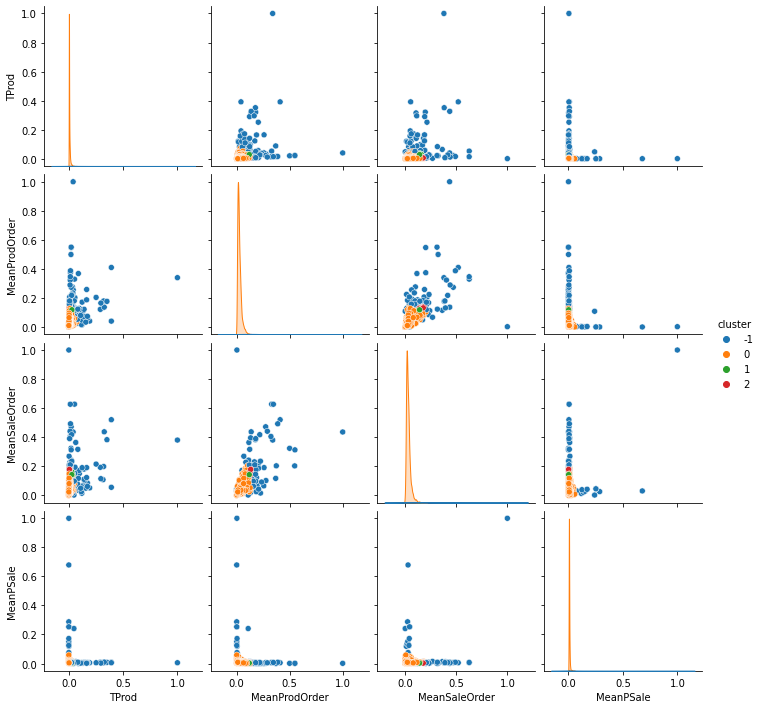

In [19]:
dbscan = DBSCAN(eps=0.02, min_samples=4).fit(df_norm)
print(np.unique(dbscan.labels_, return_counts=True))

# Extracting labels
df_norm['cluster'] = dbscan.labels_

# Pairplot
sns.pairplot(df_norm, hue='cluster', palette='tab10')
plt.show()

## Analyzing results

In [20]:
clust_list = list()
for i in tqdm(range(len(df_norm['cluster'].unique())-1), total=len(df_norm['cluster'].unique())-1, desc="Creating cluster dataframes"):
    clust_list.append(df_reduct.iloc[list(df_norm[df_norm['cluster'] == i].index)])

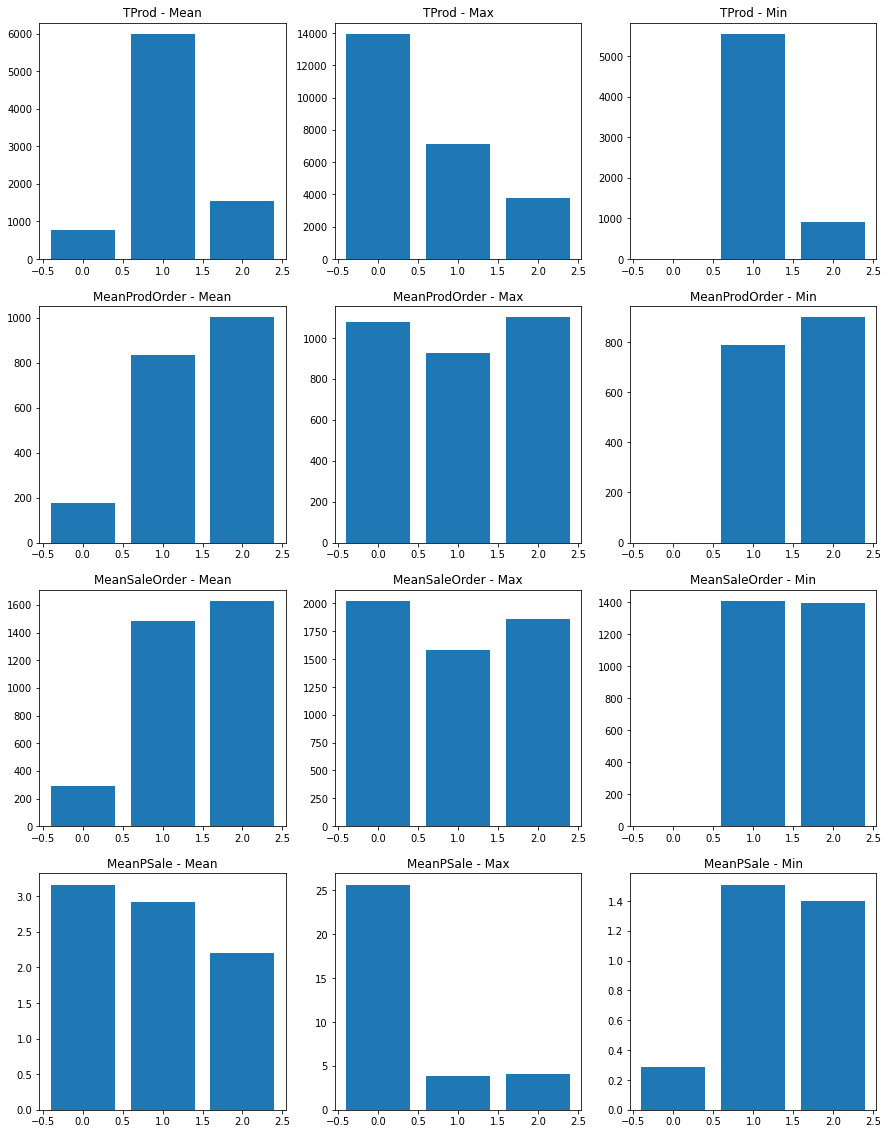

In [21]:
attr = list(df_reduct.columns)
clusters = range(len(clust_list))   # -1 to not consider the noise points
fig, axs = plt.subplots(len(attr), 3, figsize=(15,20))
for attr_index in range(len(attr)):
    avg_values = []
    max_values = []
    min_values = []
    for cluster_df in clust_list:
        stats = cluster_df.describe()
        avg_values.append(stats[attr[attr_index]][1])
        max_values.append(stats[attr[attr_index]][7])
        min_values.append(stats[attr[attr_index]][3])

    axs[attr_index][0].bar(clusters, avg_values)
    axs[attr_index][0].set_title(f"{attr[attr_index]} - Mean")
    axs[attr_index][1].bar(clusters, max_values)
    axs[attr_index][1].set_title(f"{attr[attr_index]} - Max")
    axs[attr_index][2].bar(clusters, min_values)
    axs[attr_index][2].set_title(f"{attr[attr_index]} - Min")